In [ ]:
import os
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import datetime
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import torchvision

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
modelname = 'VGG'
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set the paths for the datasets


In [ ]:
root_folder = "/content/drive/My Drive/DSAN6500_Project/Ishaan_code/wsirois_IB"
train_folder = os.path.join(root_folder, "train")
test_folder = os.path.join(root_folder, "test")
validation_folder = os.path.join(root_folder, "validation")

In [ ]:
if os.path.exists(root_folder):
    print(f"The path {root_folder} exists.")
else:
    print(f"The path {root_folder} does not exist.")

The path /content/drive/My Drive/DSAN6500_Project/Ishaan_code/wsirois_IB exists.


In [ ]:
# Create datasets
train_dataset = ImageFolder(root=train_folder, transform=transform)
test_dataset = ImageFolder(root=test_folder, transform=transform)
validation_dataset = ImageFolder(root=validation_folder, transform=transform)

batchsize = 32
numworkers = 4
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=numworkers)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False, num_workers=numworkers)
validation_loader = DataLoader(validation_dataset, batch_size=batchsize, shuffle=False, num_workers=numworkers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def train_one_epoch(model, data_loader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    top5_correct = 0
    all_labels = []
    all_predictions = []

    # Update the tqdm description to show current epoch
    for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)

         # Add top 5 accuracy
        _, top5_predicted = outputs.topk(5,1, True, True)
        top5_correct += top5_predicted.eq(labels.view(-1, 1).expand_as(top5_predicted)).sum().item()

        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, all_predictions)
    top5_accuracy = top5_correct / total_predictions
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

    return avg_loss, accuracy, top5_accuracy, precision, recall, f1

In [ ]:
def evaluate(model, data_loader, criterion, device, epoch, num_epochs, phase='Validation'):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    top5_correct = 0
    all_labels = []
    all_predictions = []

    # Update the tqdm description to show current epoch and phase (Validation or Testing)
    for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs} - {phase}"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)

        # Add top 5 accuracy
        _, top5_predicted = outputs.topk(5,1, True, True)
        top5_correct += top5_predicted.eq(labels.view(-1, 1).expand_as(top5_predicted)).sum().item()


        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, all_predictions)
    top5_accuracy = top5_correct / total_predictions
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

    return avg_loss, accuracy, top5_accuracy, precision, recall, f1

In [ ]:
from torchvision.transforms.transforms import CenterCrop


class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


mean = [0.4829, 0.4908, 0.4228]
std = [0.2297, 0.2252, 0.2601]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(224),
      #torchvision.transforms.CenterCrop(224),
      #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=mean,
          std=std
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = '/content/drive/My Drive/DSAN6500_Project/Ishaan_code/wsirois_IB/train',
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train,
    batch_size= 64,
    shuffle=True,
    num_workers=4
)

test = torchvision.datasets.ImageFolder(
    root = '/content/drive/My Drive/DSAN6500_Project/Ishaan_code/wsirois_IB/test',
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test,
    batch_size= 64,
    shuffle=True,
    num_workers=4
)

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4,4,figsize= (15,15))

for i in range(16):

  img = train[i][0].numpy().transpose(1, 2, 0)
  img = np.clip((std * img) + mean, 0, 1)
  axes.flat[i].imshow(img)
  axes.flat[i].set_title(str(train[i][1]))

# Follow aspect ratio of either 1:1 or 1.68:1 (8.5, 4.75/5)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
class CustomVGG(nn.Module):

  def __init__(self, num_classes = 200):
    super().__init__()

    self.features = nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )

    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))

    self.classifier = nn.Sequential(
      nn.Dropout(p=0.5, inplace= False),
      nn.Linear(in_features=25088, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace= False),
      nn.Linear(in_features=4096, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=4096, out_features=num_classes, bias=True)
    )

  def forward(self, x):

    x = self.features(x)
    x = self.avgpool(x)
    x = x.reshape(x.size(0), -1)
    x = self.classifier(x)

    return x

if torch.cuda.is_available():
  cuda = True


VGGscratch = CustomVGG(num_classes=200)

if cuda:
  VGGscratch.cuda()


print(VGGscratch)

CustomVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(12

In [ ]:
optimizer = optim.SGD(params = VGGscratch.parameters(),   lr= 1e-3, momentum= 0.9 )
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

In [ ]:
output_folder = "/content/drive/My Drive/DSAN6500_Project/naomi_code"

In [ ]:
import tqdm
EPOCHS = 5 # 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_loss = [np.nan]

VGGscratch.train()


pbar = tqdm.tqdm(total = EPOCHS, position= 0, leave = True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):

  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data,target) in enumerate(train_loader):

    VGGscratch.train()

    if cuda:
      print(torch.cuda.get_device_name(0))
      data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()

    out = VGGscratch(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()


    current_loss = loss.cpu().data.item()
    running_loss += current_loss


    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()



    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")


  test_running_loss = 0
  VGGscratch.eval()


  with torch.no_grad():


    for batch_idx, (data,target) in enumerate(test_loader):

      if cuda:
        data, target = data.cuda(), target.cuda()

      out = VGGscratch(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()


    LTest = test_running_loss/len(test_loader)



  LTrain=running_loss/len(train_loader)
  accu=100.*correct/total

  train_accuracy.append(accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  pbar.update()

del train_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 1: Training Loss: NA, :   0%|          | 0/5 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Tesla T4


EPOCH 1	 Batch Loss: 5.323	  Epoch Loss: nan	 Train Acc: nan	 Test Loss: nan	:   0%|          | 0/5 [01:23<?, ?it/s]

Tesla T4


EPOCH 1	 Batch Loss: 5.327	  Epoch Loss: nan	 Train Acc: nan	 Test Loss: nan	:   0%|          | 0/5 [01:25<?, ?it/s]

Tesla T4


EPOCH 1	 Batch Loss: 5.366	  Epoch Loss: nan	 Train Acc: nan	 Test Loss: nan	:   0%|          | 0/5 [01:25<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
EPOCH 1	 Batch Loss: 5.366	  Epoch Loss: 5.339	 Train Acc: 0.000	 Test Loss: 5.297	:  20%|██        | 1/5 [02:46<11:04, 166.19s/it]

Tesla T4


EPOCH 2	 Batch Loss: 5.297	  Epoch Loss: 5.339	 Train Acc: 0.000	 Test Loss: 5.297	:  20%|██        | 1/5 [03:44<11:04, 166.19s/it]

Tesla T4


EPOCH 2	 Batch Loss: 5.304	  Epoch Loss: 5.339	 Train Acc: 0.000	 Test Loss: 5.297	:  20%|██        | 1/5 [03:45<11:04, 166.19s/it]

Tesla T4


EPOCH 2	 Batch Loss: 5.349	  Epoch Loss: 5.317	 Train Acc: 0.000	 Test Loss: 5.296	:  40%|████      | 2/5 [04:43<06:51, 137.17s/it]

Tesla T4


EPOCH 3	 Batch Loss: 5.301	  Epoch Loss: 5.317	 Train Acc: 0.000	 Test Loss: 5.296	:  40%|████      | 2/5 [05:25<06:51, 137.17s/it]

Tesla T4


EPOCH 3	 Batch Loss: 5.294	  Epoch Loss: 5.317	 Train Acc: 0.000	 Test Loss: 5.296	:  40%|████      | 2/5 [05:26<06:51, 137.17s/it]

Tesla T4


EPOCH 3	 Batch Loss: 5.227	  Epoch Loss: 5.274	 Train Acc: 0.667	 Test Loss: 5.296	:  60%|██████    | 3/5 [06:06<03:45, 112.58s/it]

Tesla T4


EPOCH 4	 Batch Loss: 5.233	  Epoch Loss: 5.274	 Train Acc: 0.667	 Test Loss: 5.296	:  60%|██████    | 3/5 [06:45<03:45, 112.58s/it]

Tesla T4


EPOCH 4	 Batch Loss: 5.225	  Epoch Loss: 5.274	 Train Acc: 0.667	 Test Loss: 5.296	:  60%|██████    | 3/5 [06:48<03:45, 112.58s/it]

Tesla T4


EPOCH 4	 Batch Loss: 5.304	  Epoch Loss: 5.254	 Train Acc: 0.667	 Test Loss: 5.293	:  80%|████████  | 4/5 [07:26<01:39, 99.71s/it] 

Tesla T4


EPOCH 5	 Batch Loss: 5.241	  Epoch Loss: 5.254	 Train Acc: 0.667	 Test Loss: 5.293	:  80%|████████  | 4/5 [08:11<01:39, 99.71s/it]

Tesla T4


EPOCH 5	 Batch Loss: 5.238	  Epoch Loss: 5.254	 Train Acc: 0.667	 Test Loss: 5.293	:  80%|████████  | 4/5 [08:12<01:39, 99.71s/it]

Tesla T4


EPOCH 5	 Batch Loss: 5.265	  Epoch Loss: 5.248	 Train Acc: 2.667	 Test Loss: 5.288	: 100%|██████████| 5/5 [08:51<00:00, 94.37s/it]

<ipython-input-18-3d729c85e455>:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.library['seaborn-whitegrid']


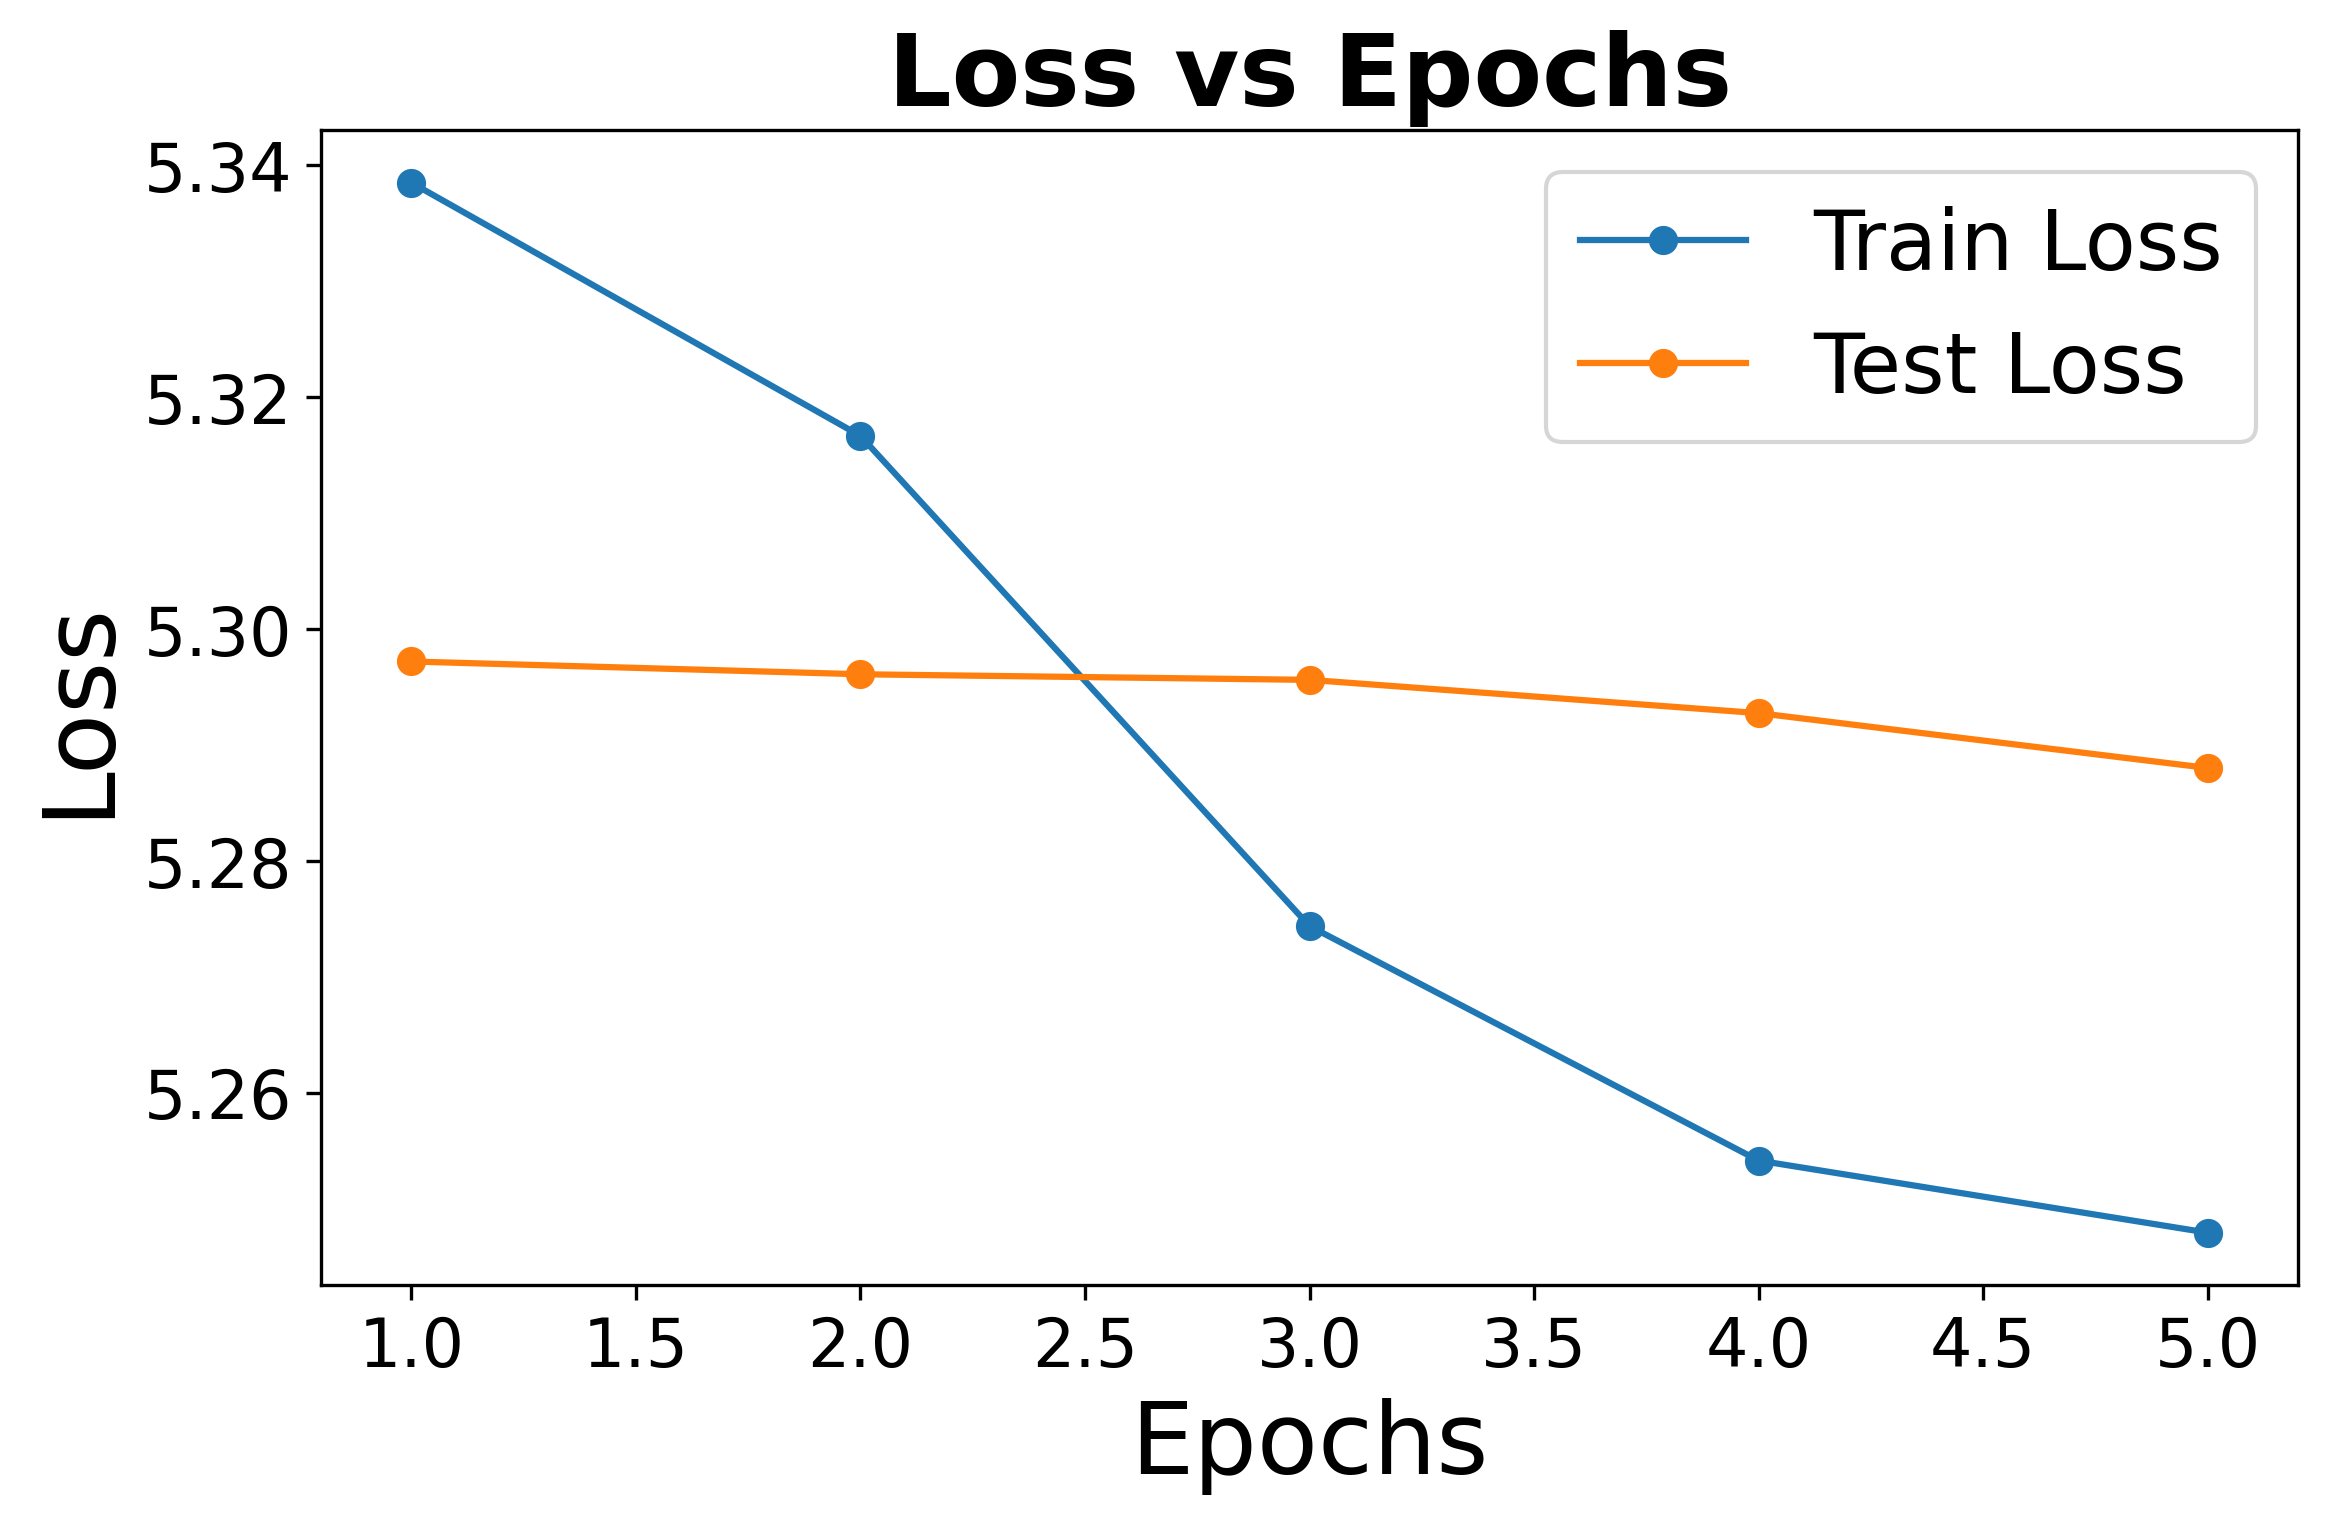

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import RcParams


myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)


fig, ax = plt.subplots(figsize =(8.5,5), dpi=300)

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss", linewidth = 1.5)
ax.plot(x, test_loss, '-o', label = "Test Loss", linewidth = 1.5)

ax.set_xlabel("Epochs", fontsize = 24)
ax.set_ylabel("Loss", fontsize = 24)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
ax.set_title("Loss vs Epochs", fontsize = 24, fontweight = 'bold')

#plt.savefig("Loss vs Epochs.jpg", dpi = 300, bbox_inches = 'tight')
#plt.savefig("Loss vs Epochs.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
correct = 0
total = 0

VGGscratch.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader): # train_loader
        if cuda:
          data, target = data.cuda(), target.cuda()

        out = VGGscratch(data)


        for _,i in enumerate(out):

            if torch.argmax(i) == target[_]:
                correct += 1
            total += 1

correct/total

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0.006666666666666667

0.006666666666666667

In [ ]:
correct = 0
total = 0

VGGscratch.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()

        out = VGGscratch(data)


        for _,i in enumerate(out):

            if target[_].cpu().item() in torch.argsort(i)[-5:].cpu().numpy():
                correct += 1
            total += 1

correct/total

0.03333333333333333

0.03333333333333333


 ## Training a Convolutional Neural Network

In [ ]:
VGGpretrained = torchvision.models.vgg16(pretrained= True)

# for p in list(VGGpretrained.parameters())[:-6]:
#   p.requires_grad = False

VGGpretrained.classifier[6] = nn.Linear(in_features=4096, out_features=200, bias=True)

cuda = torch.cuda.is_available()

if cuda:
 VGGpretrained.cuda()

print(VGGpretrained)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth

  0%|          | 0.00/528M [00:00<?, ?B/s]
  2%|▏         | 10.0M/528M [00:00<00:05, 104MB/s]
  5%|▌         | 26.5M/528M [00:00<00:03, 144MB/s]
  8%|▊         | 42.6M/528M [00:00<00:03, 155MB/s]
 12%|█▏        | 61.5M/528M [00:00<00:02, 172MB/s]
 15%|█▍ 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
optimizer = optim.SGD(params = VGGpretrained.parameters(),   lr= 1e-3, momentum= 0.9 )
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_accuracy = [np.nan]
test_loss = [np.nan]
best_test_acc = -np.inf
best_snapshot_path = None

VGGpretrained.train()


pbar = tqdm.tqdm(total = EPOCHS, position= 0, leave = True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):

  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data,target) in enumerate(train_loader):

    VGGpretrained.train()

    if cuda:
      data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()

    out = VGGpretrained(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()


    current_loss = loss.cpu().data.item()
    running_loss += current_loss


    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()

    #scheduler.step()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")


  test_total, test_correct, test_running_loss = 0, 0, 0
  VGGpretrained.eval()


  with torch.no_grad():


    for batch_idx, (data,target) in enumerate(test_loader):

      if cuda:
        data, target = data.cuda(), target.cuda()

      out = VGGpretrained(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()

      _, predicted = out.max(1)
      test_total += target.size(0)
      test_correct += predicted.eq(target).sum().cpu().item()


    test_accu=100.*test_correct/test_total
    LTest = test_running_loss/len(test_loader)

    if test_accu > best_test_acc:
      best_test_acc = test_accu

      if best_snapshot_path is not None:
        os.remove(best_snapshot_path)

      best_snapshot_path = os.path.join(f'VGG_ep={epoch + 1}_acc={best_test_acc:.2f}.pt')
      torch.save(VGGpretrained.state_dict(), best_snapshot_path)


  LTrain=running_loss/len(train_loader)
  accu=100.*correct/total

  train_accuracy.append(accu)
  test_accuracy.append(test_accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")

  pbar.update()

del train_accuracy[0]
del test_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 5	 Batch Loss: 5.265	  Epoch Loss: 5.248	 Train Acc: 2.667	 Test Loss: 5.288	: 100%|██████████| 5/5 [10:19<00:00, 123.82s/it]
EPOCH 50	 Batch Loss: 0.112	  Epoch Loss: 0.081	 Train Acc: 96.667%	 Test Loss: 0.002	 Test Acc: 100.000%	: 100%|██████████| 50/50 [1:07:19<00:00, 78.50s/it]

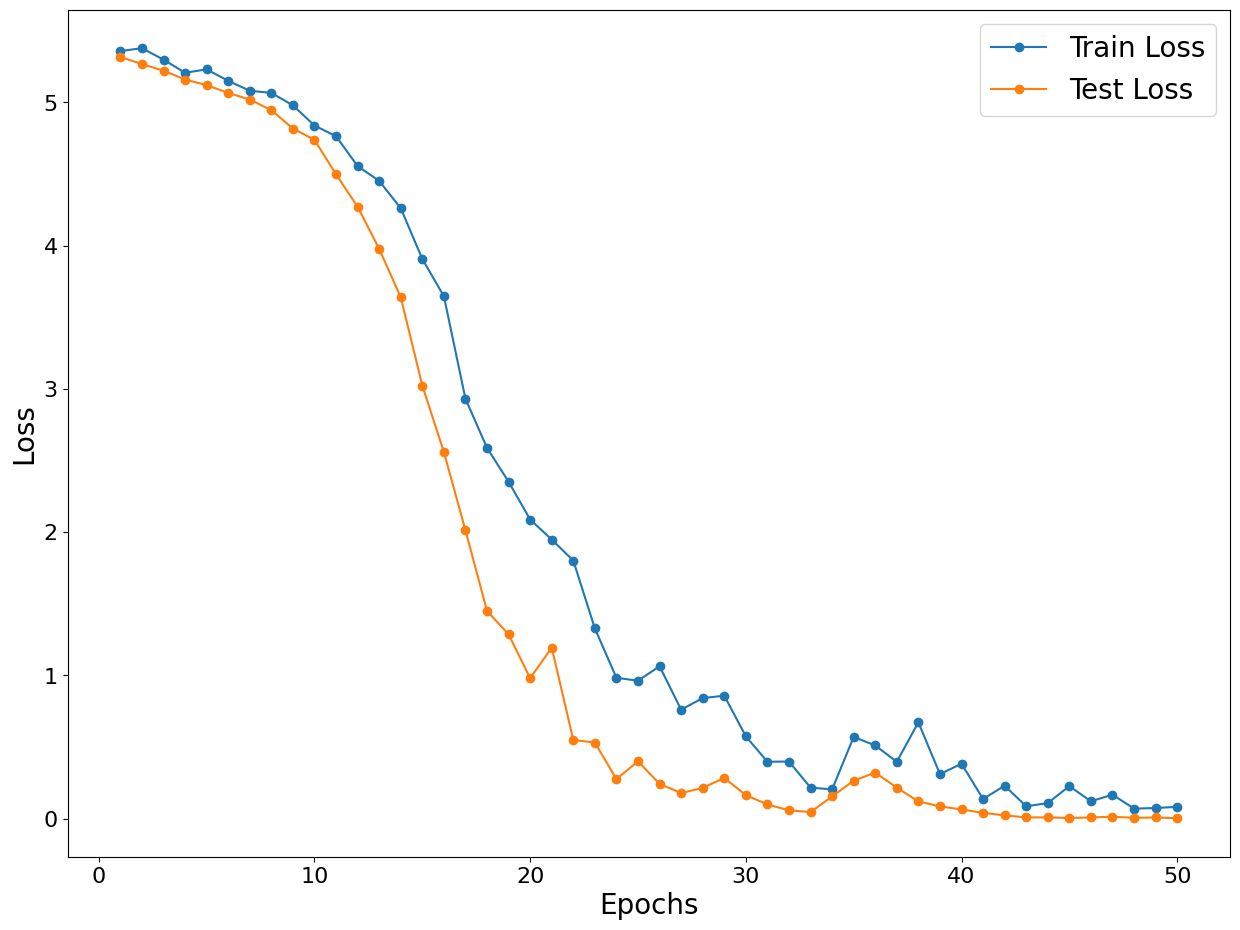

In [ ]:
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss")
ax.plot(x, test_loss, '-o', label = "Test Loss")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Loss", fontsize = 20)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)

plt.show()

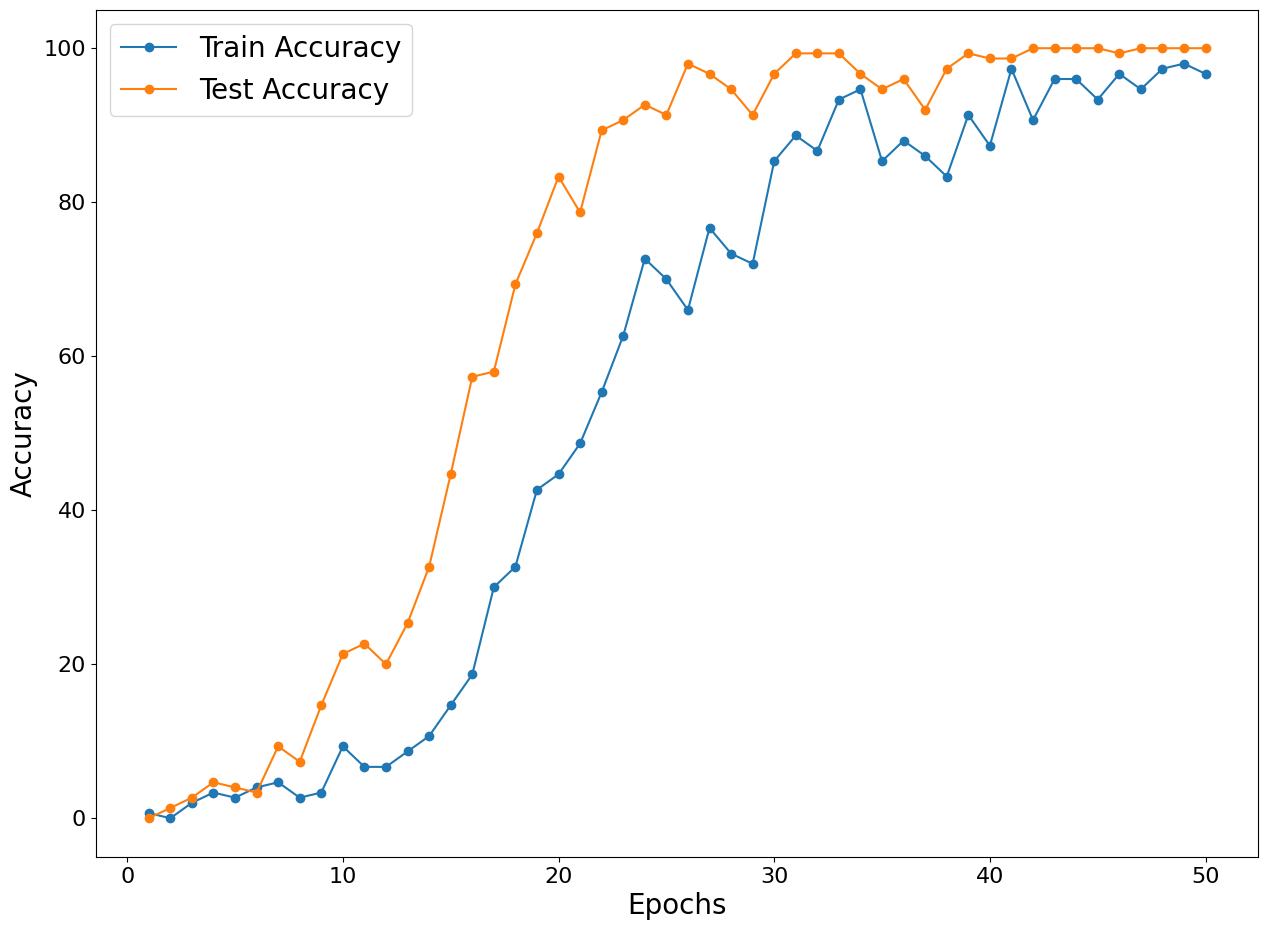

In [ ]:
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_accuracy)+1)

ax.plot(x, train_accuracy, '-o', label = "Train Accuracy")
ax.plot(x, test_accuracy, '-o', label = "Test Accuracy")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)

plt.show()

In [ ]:
#VGGpretrained.load_state_dict(torch.load(best_snapshot_path))

In [ ]:
correct = 0
total = 0

VGGpretrained.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()

        out = VGGpretrained(data)


        for _,i in enumerate(out):

            if torch.argmax(i) == target[_]:
                correct += 1
            total += 1

correct/total

1.0

1.0

In [ ]:
correct = 0
total = 0

VGGpretrained.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()

        out = VGGpretrained(data)


        for _,i in enumerate(out):

            if target[_].cpu().item() in torch.argsort(i)[-5:].cpu().numpy():
                correct += 1
            total += 1

correct/total

1.0

1.0

## Evaluating a Convolutional Neural Network

In [ ]:
from torchvision.transforms.transforms import CenterCrop


class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


mean = [0.4829, 0.4908, 0.4228]
std = [0.2297, 0.2252, 0.2601]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(448),
      #torchvision.transforms.CenterCrop(224),
      #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=mean,
          std=std
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = '/content/drive/My Drive/DSAN6500_Project/Ishaan_code/wsirois_IB/train',
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train,
    batch_size= 32,
    shuffle=True,
    num_workers=4
)

test = torchvision.datasets.ImageFolder(
    root = '/content/drive/My Drive/DSAN6500_Project/Ishaan_code/wsirois_IB/test',
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test,
    batch_size= 32,
    shuffle=True,
    num_workers=4
)

In [ ]:
class VGGalter(nn.Module):

  def __init__(self):
    super().__init__()

    self.VGG =  torchvision.models.vgg16(pretrained= True)
    self.VGG.features[30] = nn.MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)

    self.FC4 = nn.Sequential(
        nn.ReLU(inplace = True),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features=1000, out_features=200, bias=True)
    )


  def forward(self, x):

    x = self.VGG.features(x)
    x = self.VGG.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.VGG.classifier(x)

    x = self.FC4(x)

    return x


ComplexVGG = VGGalter()


cuda = torch.cuda.is_available()


if cuda:
 ComplexVGG.cuda()

print(ComplexVGG)

VGGalter(
  (VGG): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

In [ ]:
optimizer = optim.SGD(params = ComplexVGG.parameters(),   lr= 1e-3, momentum= 0.9 )
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_accuracy = [np.nan]
test_loss = [np.nan]
best_test_acc = -np.inf
best_snapshot_path = None

ComplexVGG.train()


pbar = tqdm.tqdm(total = EPOCHS, position= 0, leave = True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):

  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data,target) in enumerate(train_loader):

    ComplexVGG.train()

    if cuda:
      data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()

    out = ComplexVGG(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()


    current_loss = loss.cpu().data.item()
    running_loss += current_loss


    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()

    #scheduler.step()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")


  test_total, test_correct, test_running_loss = 0, 0, 0
  ComplexVGG.eval()


  with torch.no_grad():


    for batch_idx, (data,target) in enumerate(test_loader):

      if cuda:
        data, target = data.cuda(), target.cuda()

      out = ComplexVGG(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()

      _, predicted = out.max(1)
      test_total += target.size(0)
      test_correct += predicted.eq(target).sum().cpu().item()


    test_accu=100.*test_correct/test_total
    LTest = test_running_loss/len(test_loader)

    if test_accu > best_test_acc:
      best_test_acc = test_accu

      if best_snapshot_path is not None:
        os.remove(best_snapshot_path)

      best_snapshot_path = os.path.join(f'VGGCustom_ep={epoch + 1}_acc={best_test_acc:.2f}.pt')
      torch.save(ComplexVGG.state_dict(), best_snapshot_path)


  LTrain=running_loss/len(train_loader)
  accu=100.*correct/total

  train_accuracy.append(accu)
  test_accuracy.append(test_accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")

  pbar.update()

del train_accuracy[0]
del test_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 50	 Batch Loss: 0.112	  Epoch Loss: 0.081	 Train Acc: 96.667%	 Test Loss: 0.002	 Test Acc: 100.000%	: 100%|██████████| 50/50 [1:08:41<00:00, 82.43s/it]
EPOCH 50	 Batch Loss: 0.535	  Epoch Loss: 0.605	 Train Acc: 82.000%	 Test Loss: 0.093	 Test Acc: 97.333%	: 100%|██████████| 50/50 [1:18:03<00:00, 87.73s/it]

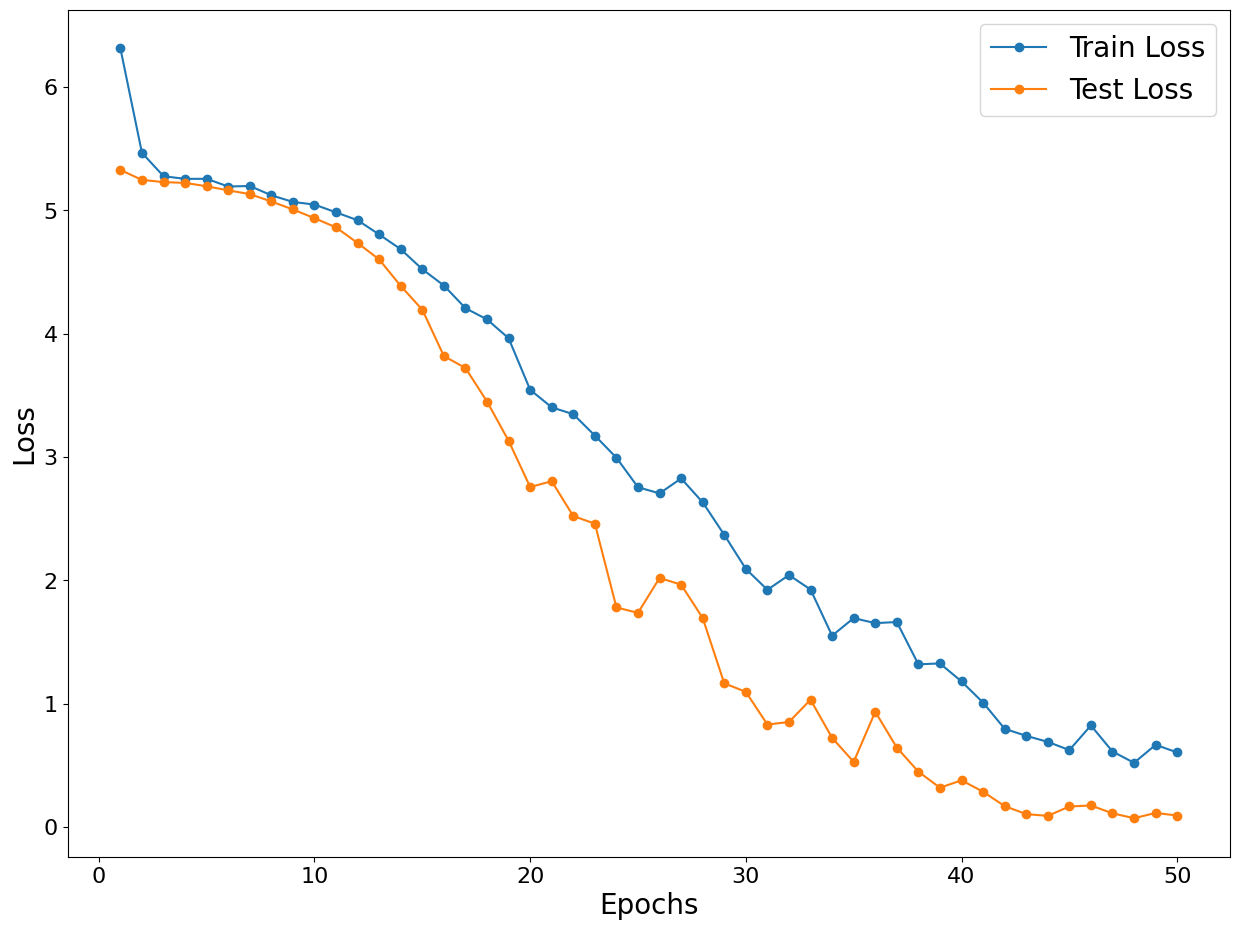

In [ ]:
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss")
ax.plot(x, test_loss, '-o', label = "Test Loss")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Loss", fontsize = 20)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)

plt.show()

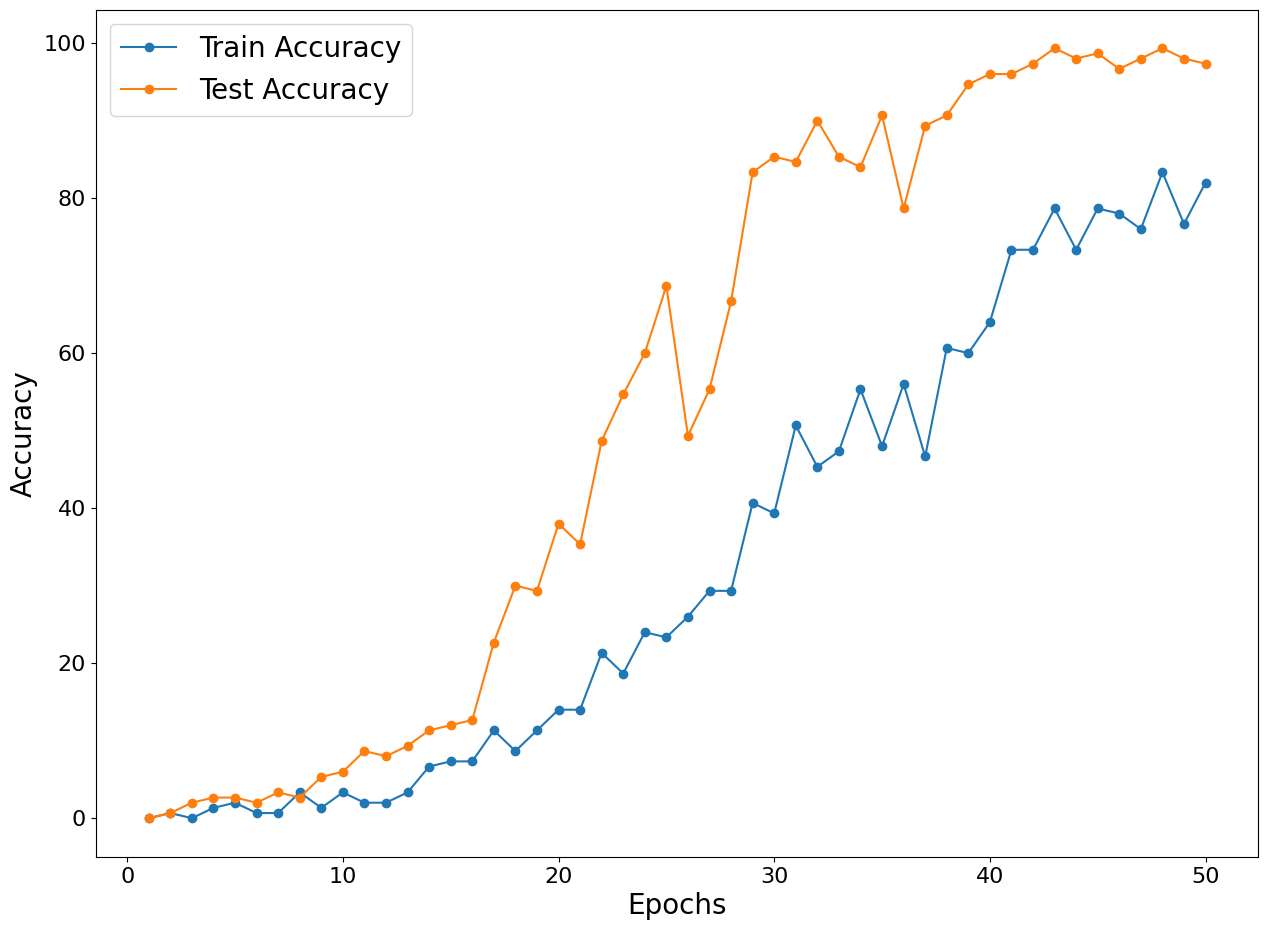

In [ ]:
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_accuracy)+1)

ax.plot(x, train_accuracy, '-o', label = "Train Accuracy")
ax.plot(x, test_accuracy, '-o', label = "Test Accuracy")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)

plt.show()

In [ ]:
#ComplexVGG.load_state_dict(torch.load(best_snapshot_path))

In [ ]:
correct = 0
total = 0

ComplexVGG.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()

        out = ComplexVGG(data)


        for _,i in enumerate(out):

            if torch.argmax(i) == target[_]:
                correct += 1
            total += 1

correct/total

0.9866666666666667

0.9866666666666667


In [ ]:
correct = 0
total = 0

ComplexVGG.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()

        out = ComplexVGG(data)


        for _,i in enumerate(out):

            if target[_].cpu().item() in torch.argsort(i)[-5:].cpu().numpy():
                correct += 1
            total += 1

correct/total

1.0

1.0

In [ ]:
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

ComplexVGG.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()

        out = ComplexVGG(data)


        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

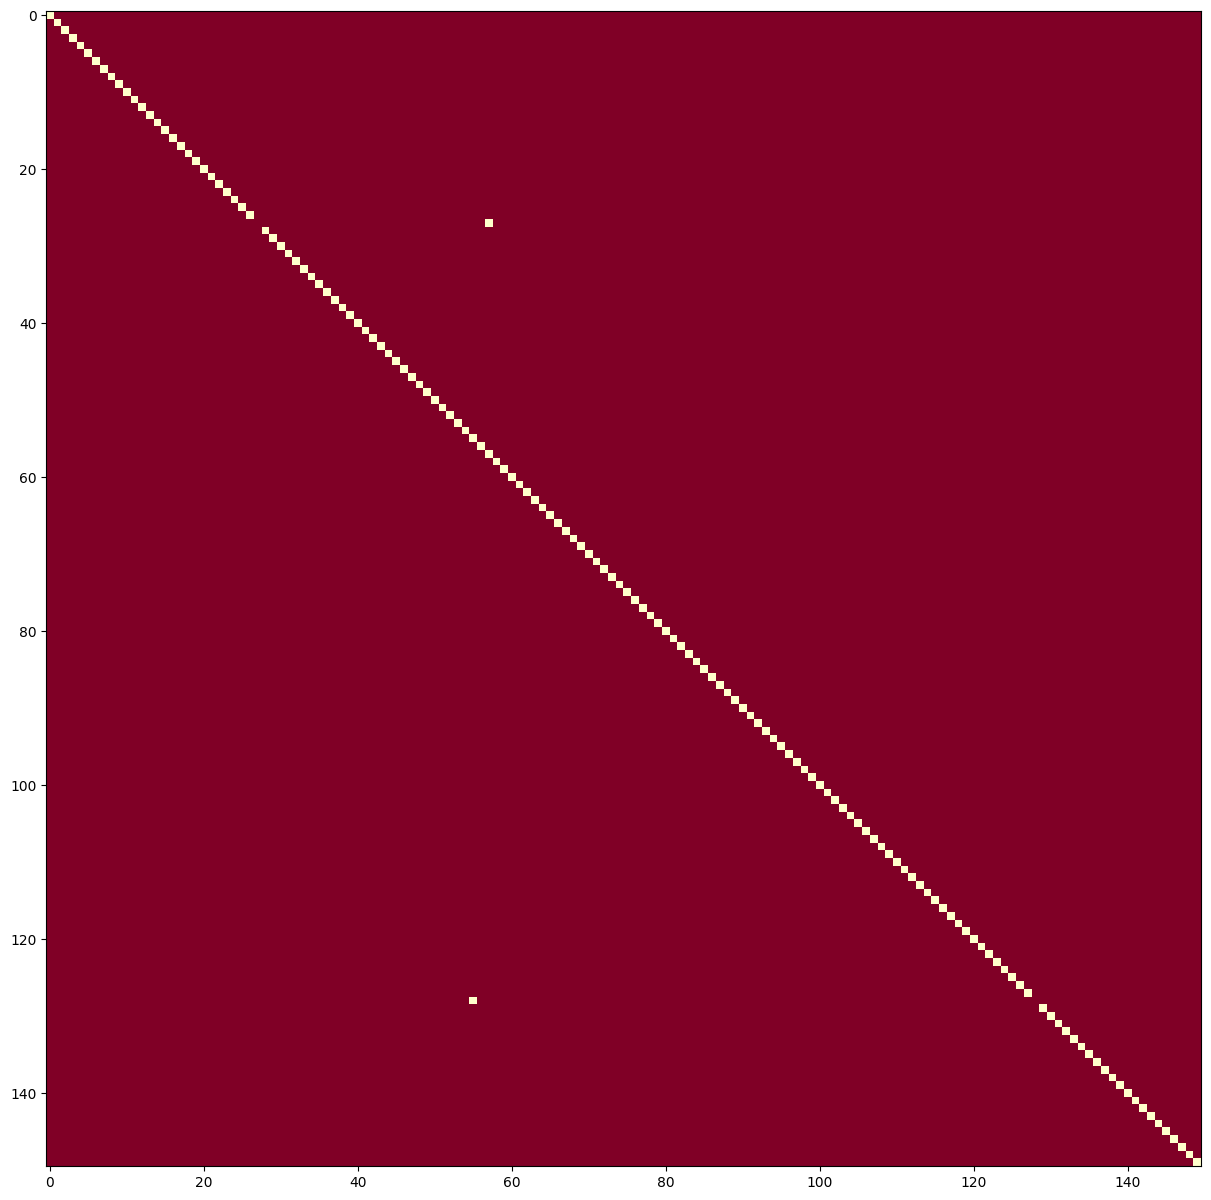

In [ ]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_pred= pred, y_true = correct)

fig,ax = plt.subplots(figsize = (15,15))

plt.imshow(conf, interpolation='none', cmap = 'YlOrRd_r')

In [ ]:
# !jupyter nbconvert --execute --to html 'Lab08-VGG_image_classification.ipynb'
#!jupyter nbconvert --to html 'Lab08-VGG_image_classification.ipynb'